In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K

In [9]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Failed to detect a GPU.


In [5]:
INIT_LR = 1e-3
batch_size = 32
img_height = 256
img_width =256
epochs = 50
image_size = 0
channels = 3
autotune = tf.data.AUTOTUNE

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "image_data",
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

NotFoundError: Could not find directory image_data

In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

8 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Rice_Bacterial_leaf_blight', 'Rice_Brown_spot', 'Rice_Healthy', 'Rice_Leaf_Blast', 'Rice_Leaf_Smut']


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "image_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4809 files belonging to 8 classes.
Using 961 files for validation.


In [8]:
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1.0/255)
])


In [11]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

In [12]:
input_shape = (img_height, img_width, channels)
batch_input_shape = (batch_size, img_height, img_width, channels)
chainDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (channels, img_height, img_width)
    batch_input_shape = (batch_size, channels, img_height, img_width)
    chanDim = -1

In [13]:
model = models.Sequential([
    tf.keras.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  
])

In [14]:
from tensorflow.keras.optimizers.legacy import Adam
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [2]:
model.summary()

NameError: name 'model' is not defined

In [17]:
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 162s 896ms/step - accuracy: 0.3131 - loss: 1.6213 - val_accuracy: 0.5900 - val_loss: 0.9609
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 91s 745ms/step - accuracy: 0.6446 - loss: 0.8662 - val_accuracy: 0.6930 - val_loss: 0.7015
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 687ms/step - accuracy: 0.6904 - loss: 0.7479 - val_accuracy: 0.7014 - val_loss: 0.7156
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 665ms/step - accuracy: 0.7225 - loss: 0.6400 - val_accuracy: 0.7284 - val_loss: 0.6121
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 673ms/step - accuracy: 0.7380 - loss: 0.6015 - val_accuracy: 0.7118 - val_loss: 0.6554
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 86s 709ms/step - accuracy: 0.7402 - loss: 0.5701 - val_accuracy: 0.7565 - val_loss: 0.5315
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - accuracy: 0.7716 - loss: 0.5083 - val_accuracy: 0.7617 - val_loss: 0.4995
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 674ms/step - accuracy: 0.7558 - loss: 

[0.40176716446876526, 0.6515072584152222, 0.7053014636039734, 0.7255717515945435, 0.7325883507728577, 0.7435030937194824, 0.7632536292076111, 0.7645530104637146, 0.7533783912658691, 0.784563422203064, 0.7824844121932983, 0.7895010113716125, 0.797817051410675, 0.7965176701545715, 0.8071725368499756, 0.8063929080963135, 0.8032744526863098, 0.829781711101532, 0.8141891956329346, 0.8201663494110107, 0.8266631960868835, 0.8367983102798462, 0.822765052318573, 0.8386174440383911, 0.8180873394012451, 0.8347193598747253, 0.8440748453140259, 0.8375779390335083, 0.8531704545021057, 0.859927237033844, 0.8503118753433228, 0.8620062470436096, 0.8581081032752991, 0.8620062470436096, 0.8516111969947815, 0.8726611137390137, 0.8708419799804688, 0.8861746191978455, 0.8983888030052185, 0.8898128867149353, 0.9054054021835327, 0.9061850309371948, 0.9137214422225952, 0.9048856496810913, 0.9165800213813782, 0.9196985363960266, 0.9168398976325989, 0.9215176701545715, 0.9248960614204407, 0.9251559376716614]
[0.

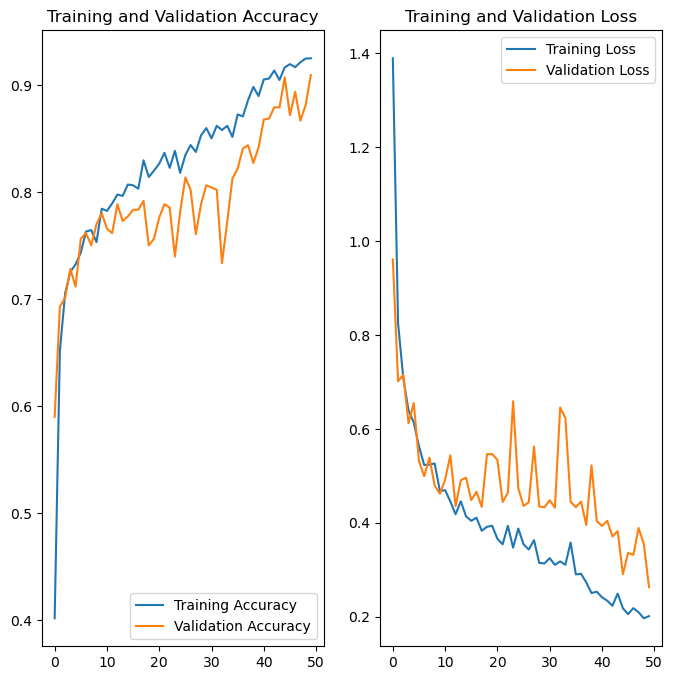

In [160]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)
print (loss)
print(val_loss)
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


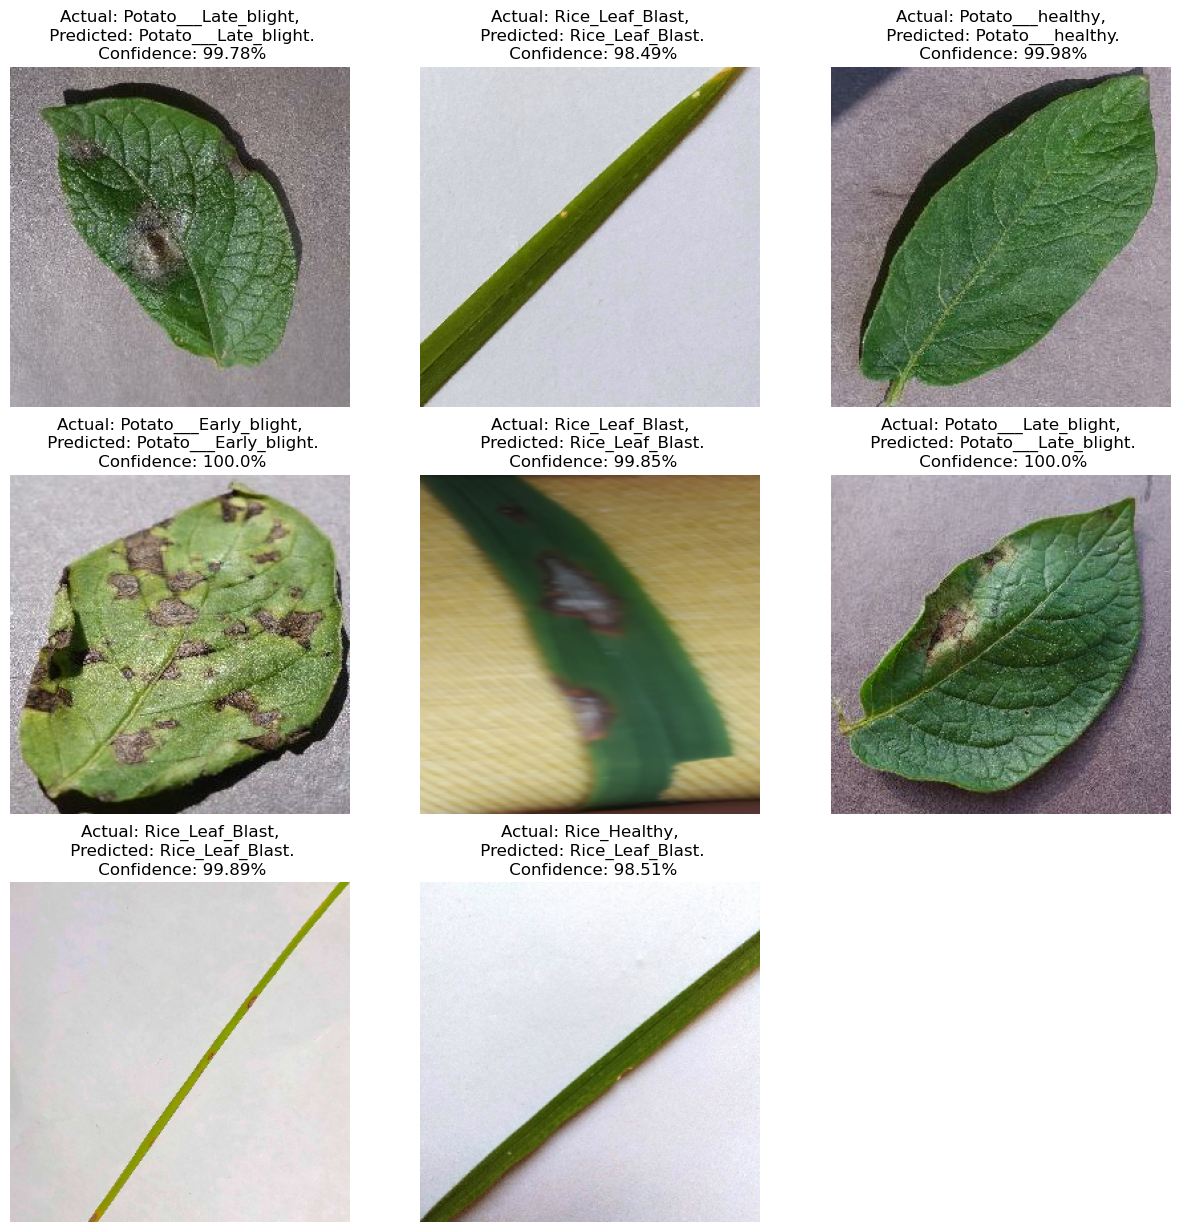

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

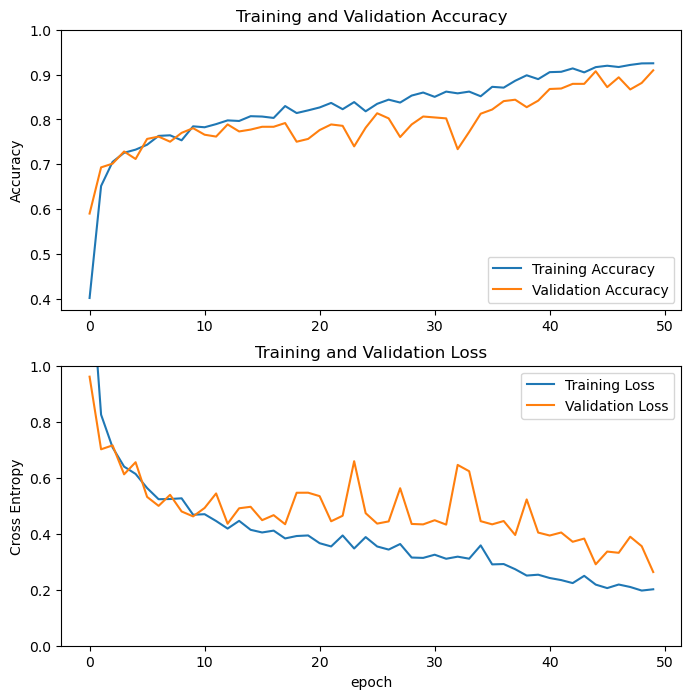

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [161]:
loss, accuracy = model.evaluate(val_ds)


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8983 - loss: 0.2984


In [162]:
loss,accuracy = model.evaluate(train_ds)

121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 234ms/step - accuracy: 0.9357 - loss: 0.1662


In [163]:
loss,accuracy = model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9333 - loss: 0.2069


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
predicted label: Potato___Early_blight


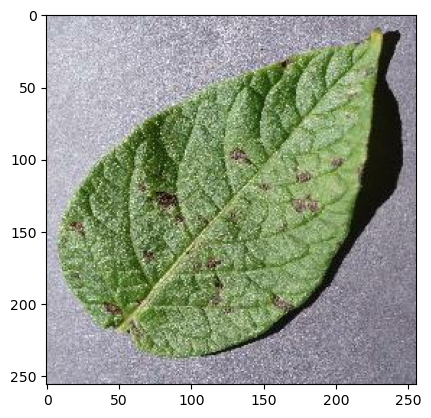

In [71]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


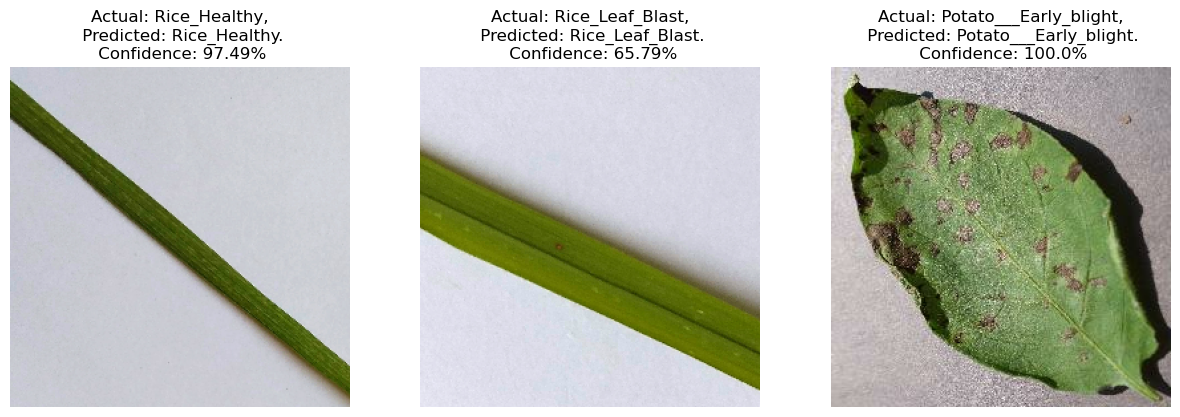

In [184]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [95]:
loss, acc = model.evaluate(test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(model.predict(test_ds).shape)

13/13 - 2s - 127ms/step - accuracy: 0.9471 - loss: 0.1606
Restored model, accuracy: 94.71%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
(416, 8)


In [99]:
model.save('new_model.keras')

In [130]:
y_pred = model.predict(test_ds)
print(y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
[[9.99820530e-01 1.79470488e-04 1.76064878e-13 ... 1.70950588e-13
  6.08107897e-10 1.38819563e-11]
 [9.99997973e-01 1.98303610e-06 7.55679460e-12 ... 9.70085659e-16
  8.10066857e-13 3.74634048e-08]
 [4.54375986e-08 4.87493082e-07 6.42849329e-07 ... 9.74052787e-01
  2.59411503e-02 3.12145403e-06]
 ...
 [5.71658078e-04 9.99427617e-01 3.81029821e-07 ... 1.09386935e-08
  2.65401127e-07 2.36369344e-11]
 [1.23737019e-03 9.98760939e-01 1.25888266e-06 ... 1.41905886e-07
  3.04586251e-07 7.37164718e-10]
 [2.48554310e-09 1.54257904e-07 1.11778480e-08 ... 9.87548709e-01
  1.24507127e-02 1.62690952e-07]]


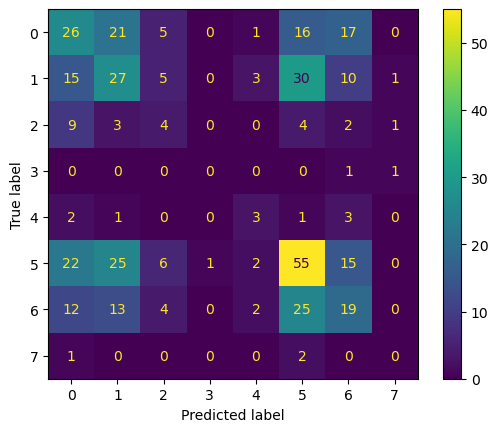

In [159]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)

cr = classification_report(predicted_categories, true_categories)

cmd = ConfusionMatrixDisplay.from_predictions(true_categories, predicted_categories)
print(cmd)

In [115]:
import tensorflow as tf
model=tf.keras.models.load_model("new_model.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model1.tflite", "wb").write(tflite_model) 

INFO:tensorflow:Assets written to: C:\Users\yeami\AppData\Local\Temp\tmp2tk9qstw\assets


INFO:tensorflow:Assets written to: C:\Users\yeami\AppData\Local\Temp\tmp2tk9qstw\assets


Saved artifact at 'C:\Users\yeami\AppData\Local\Temp\tmp2tk9qstw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1927843879952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843881104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843879760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843882064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843882256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843882832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843881680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843883792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843883984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1927843884560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  192784

742444

In [1]:
from sklearn.metrics import classification_report